문제 정의: Lasso 회귀 분석 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비(MPG) 예측

기본 라이브러리 불러오기

In [ ]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 한글 깨짐 방지
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


[Step 1] 데이터 준비 - read_csv() 함수로 자동차 연비 데이터셋 가져오기

In [ ]:
# csv 파일을 데이터프레임으로 변환
df = pandas.read_csv('/content/auto-mpg.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [ ]:
# 열 이름 지정
df.columns = ['mpg','cylinders','displacement','horsepower','weight',
              'acceleration','model year','origin','name']

데이터 살펴보기

In [ ]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


[Step 2] 데이터 탐색 및 데이터 전처리

In [ ]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [ ]:
# horsepower 열의 자료형 (문자열 -> 숫자)
df['horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [ ]:
# '?'를 numpy.nan으로
df['horsepower'].replace('?', numpy.nan, inplace = True)

In [ ]:
# 누락 데이터(numpy.nan)를 삭제
df.dropna(subset = ['horsepower'], axis = 0, inplace = True)

In [ ]:
# 문자열 -> 숫자로 변환
df['horsepower'] = df['horsepower'].astype('float')

[Step 3] 속성(feature 또는 variable) 선택

In [ ]:
# 분석에 활용할 속성을 선택 (연비, 실린더, 출력(마력), 중량)
ndf = df[['mpg', 'cylinders', 'horsepower', 'weight']]
ndf.head()

,mpg,cylinders,horsepower,weight
0,18.0,8,130.0,3504.0
1,15.0,8,165.0,3693.0
2,18.0,8,150.0,3436.0
3,16.0,8,150.0,3433.0
4,17.0,8,140.0,3449.0


[Step 4] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)

In [ ]:
# 속성(변수) 선택
X = ndf[['weight', 'cylinders', 'horsepower']] # 독립 변수 x1, x2, x3
y = ndf['mpg']  # 종속 변수 y

In [ ]:
# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,                  # 독립 변수
                                                    y,                  # 종속 변수
                                                    test_size = 0.3,    # 검증 30%
                                                    random_state = 10)  # 랜덤 추출 값 (시드)

[Step 5] Lasso 회귀분석 모형 - sklearn 사용

In [ ]:
# sklearn 라이브러리에서 Lasso 회귀분석 모듈 가져오기
from sklearn.linear_model import Lasso

# Lasso 회귀분석 모형 객체 생성 후 학습시키기
lasso001 = Lasso(alpha = 5).fit(X_train, y_train)

[Step 6] 성능 평가하기

In [ ]:
r_square = lasso001.score(X_test, y_test)
r_square

0.6967667760427846

In [ ]:
# 모형에 전체 X 데이터를 입력하여 예측한 값을 y_hat으로 담기
y_hat = lasso001.predict(X)

In [ ]:
# 모형에 테스트셋 X_test 데이터를 입력하여 예측한 값을 y_hat_test으로 담기
y_hat_test = lasso001.predict(X_test)

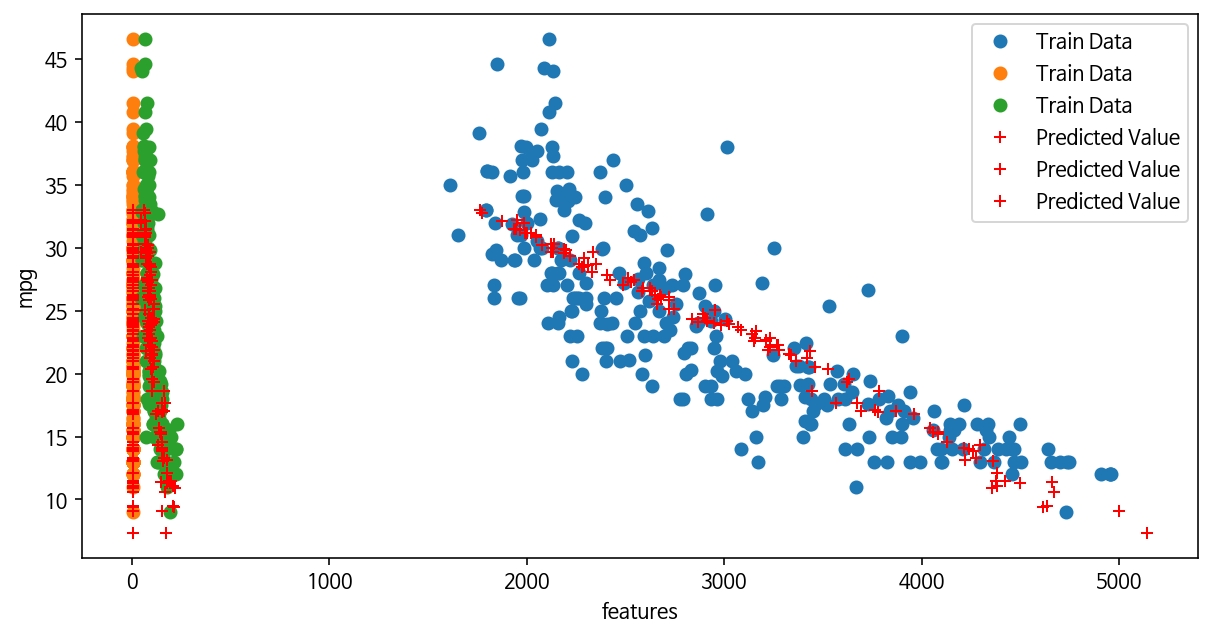

In [ ]:
# train 데이터(X_train)의 산점도와 test 데이터(X_test)로 예측한 (y_hat_test) 회귀선을 그래프로 출력

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train, y_train, 'o', label = 'Train Data')  # 데이터의 분포
ax.plot(X_test, y_hat_test, 'r+', label = 'Predicted Value')  # 모형이 예측한 회귀선
ax.legend(loc = 'best')
plt.xlabel('features')
plt.ylabel('mpg')
plt.show()

In [ ]:
print('훈련 세트 정확도 :{:.2f}%'.format(lasso001.score(X_train, y_train)*100))
print('테스트 세트 정확도 :{:.2f}%'.format(lasso001.score(X_test, y_test)*100))

훈련 세트 정확도 :70.33%
테스트 세트 정확도 :69.68%


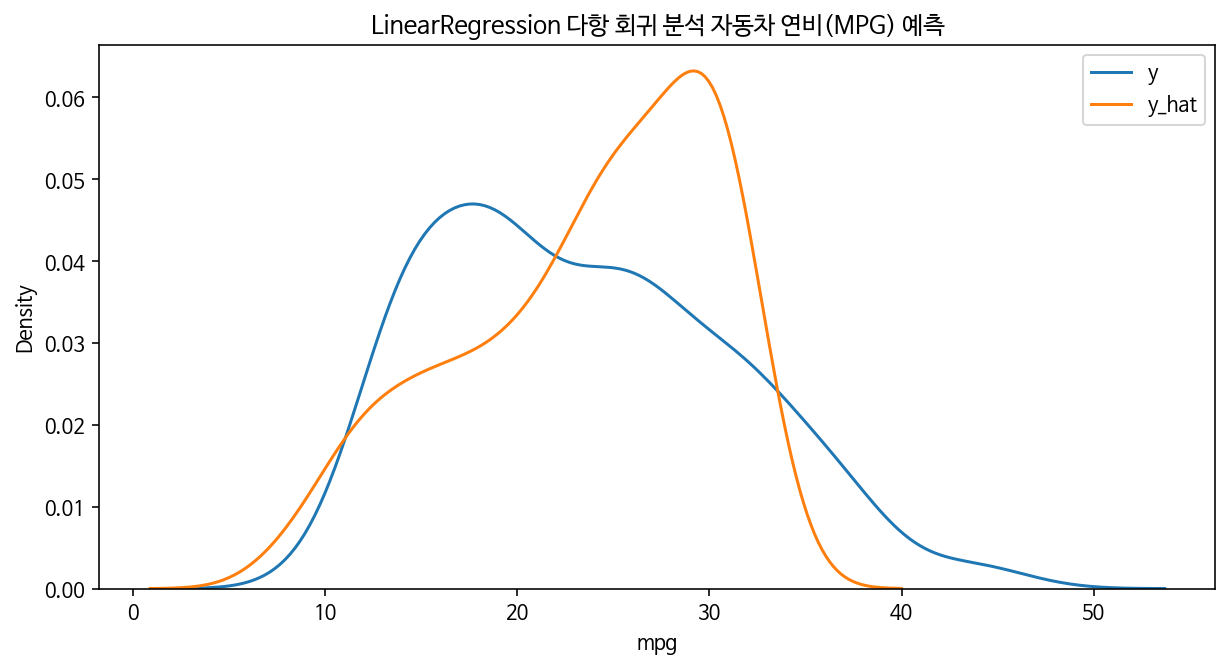

In [ ]:
plt.figure(figsize = (10, 5))
ax1 = sns.kdeplot(y, label = 'y')
ax2 = sns.kdeplot(y_hat, label = 'y_hat', ax=ax1)
plt.title('LinearRegression 다항 회귀 분석 자동차 연비(MPG) 예측')
plt.legend()
plt.show()

릿지

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 300).fit(X_train, y_train)

In [ ]:
r_square = ridge.score(X_test, y_test)
r_square

0.7268003148622003

In [ ]:
# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,                  # 독립 변수
                                                    y,                  # 종속 변수
                                                    test_size = 0.3,    # 검증 30%
                                                    random_state = 7)  # 랜덤 추출 값 (시드)

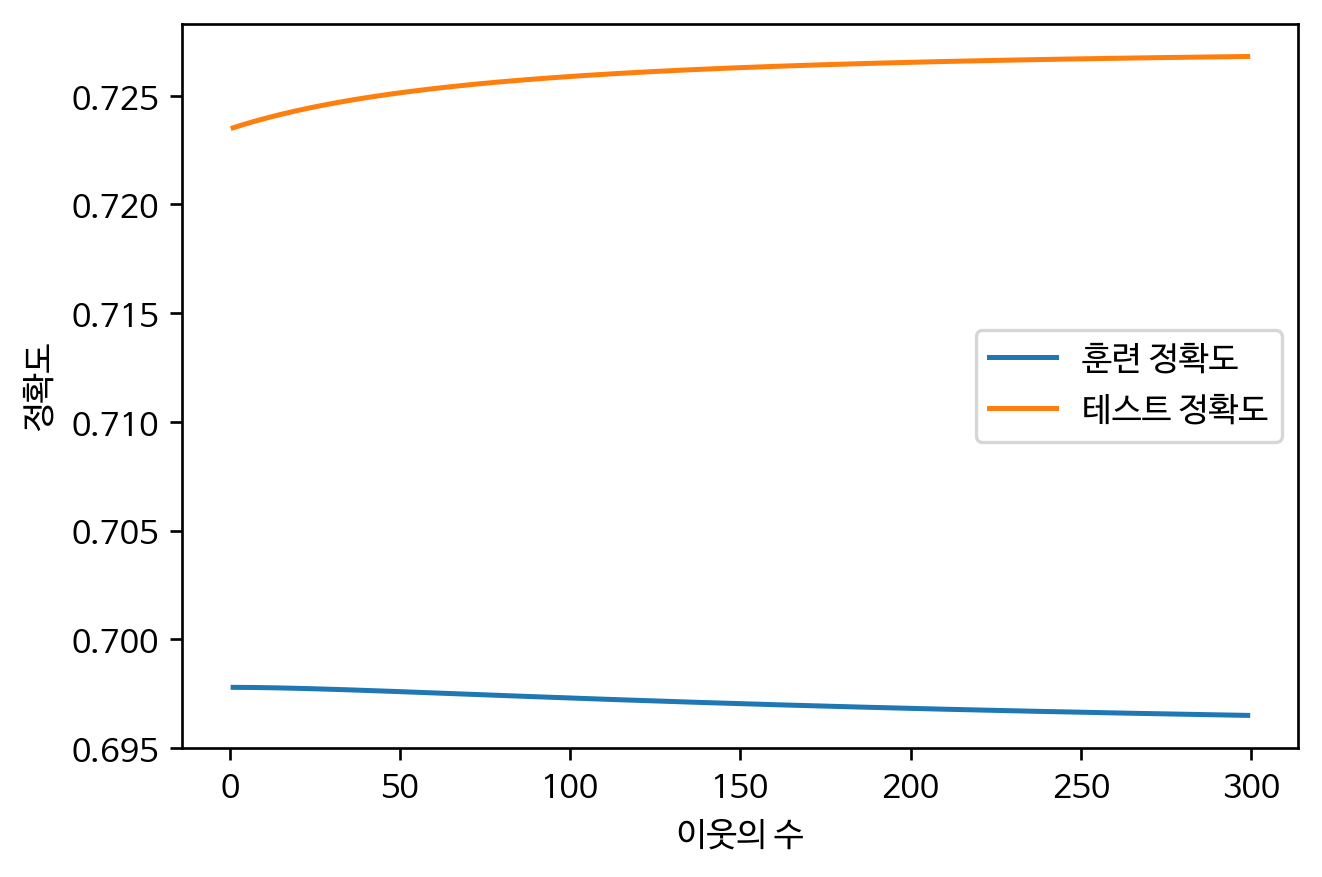

In [ ]:
# 알파에 따른 정확도 저장할 리스트 변수
train_accuracy = []
test_accuracy = []

# n_alpha를 적용
alpha_settings = range(1, 300)

for n_alpha in alpha_settings:
  ridge = Ridge(alpha = n_alpha).fit(X_train, y_train)
  
  # 훈련 세트 정확도 저장
  train_accuracy.append(ridge.score(X_train, y_train))

  # 테스트 세트 정확도 저장
  test_accuracy.append(ridge.score(X_test, y_test))

# 훈련 vs 테스트 정확도 시각화
plt.figure(dpi = 120)
plt.rc('font', family='NanumBarunGothic')

plt.plot(alpha_settings, train_accuracy, label = '훈련 정확도')
plt.plot(alpha_settings, test_accuracy, label = '테스트 정확도')
plt.ylabel('정확도')
plt.xlabel('이웃의 수')
plt.legend()
plt.show()    # 테스트 정확도가 높은 5를 골라라

In [ ]:
for i in range(500):
  ridge = Ridge(alpha = i).fit(X_train, y_train)
  print(ridge.score(X_test, y_test))

0.6939048496695601
0.6939700014000185
0.6940336470405544
0.6940958326835875
0.6941566026711993
0.6942159996743017
0.6942740647676616
0.6943308375010251
0.6943863559665696
0.6944406568629016
0.6944937755558009
0.694545746135895
0.6945966014734444
0.6946463732704011
0.6946950921098929
0.6947427875032827
0.6947894879349295
0.6948352209047874
0.6948800129689567
0.6949238897782961
0.6949668761152085
0.6950089959286919
0.6950502723677519
0.6950907278132596
0.6951303839083429
0.6951692615873794
0.6952073811036726
0.6952447620558735
0.6952814234132108
0.6953173835396024
0.695352660216686
0.6953872706658404
0.6954212315692392
0.6954545590899863
0.695487268891381
0.6955193761553533
0.6955508956001097
0.6955818414970311
0.6956122276868537
0.6956420675951737
0.6956713742473017
0.6957001602825016
0.6957284379676419
0.6957562192102886
0.6957835155712611
0.6958103382766821
0.6958366982295391
0.6958626060207846
0.6958880719399945
0.6959131059856
0.6959377178747215
0.6959619170526147
0.6959857127017479

In [ ]:
# 모형에 전체 X 데이터를 입력하여 예측한 값을 y_hat으로 담기
y_hat = ridge.predict(X)

In [ ]:
# 모형에 테스트셋 X_test 데이터를 입력하여 예측한 값을 y_hat_test으로 담기
y_hat_test = ridge.predict(X_test)

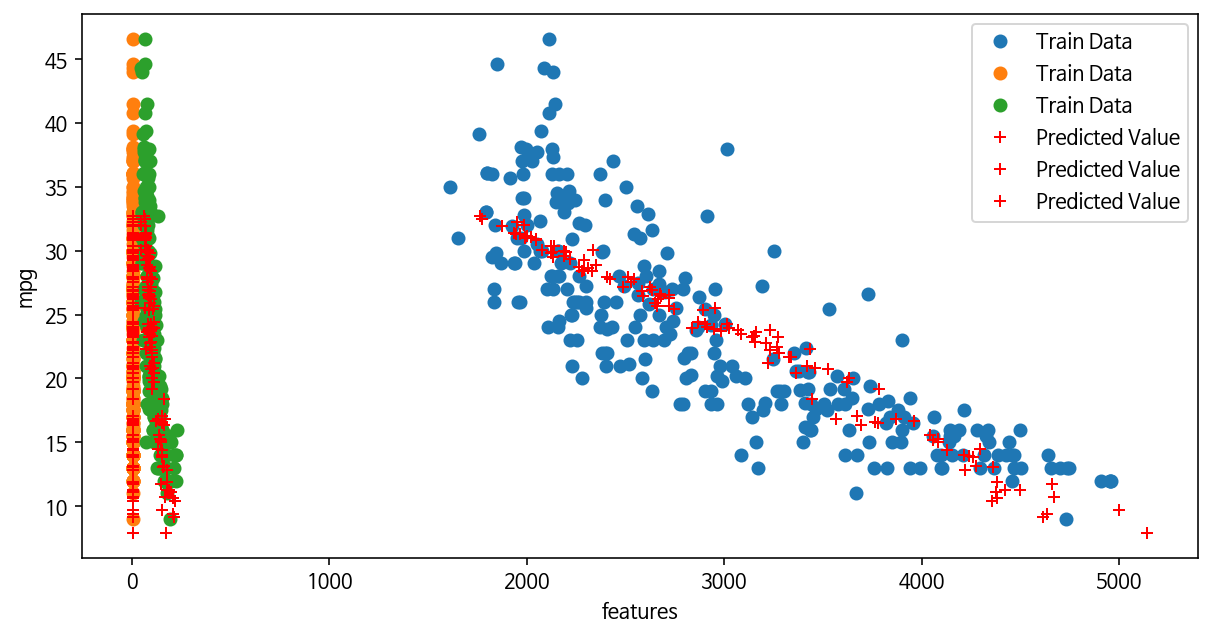

In [ ]:
# train 데이터(X_train)의 산점도와 test 데이터(X_test)로 예측한 (y_hat_test) 회귀선을 그래프로 출력

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train, y_train, 'o', label = 'Train Data')  # 데이터의 분포
ax.plot(X_test, y_hat_test, 'r+', label = 'Predicted Value')  # 모형이 예측한 회귀선
ax.legend(loc = 'best')
plt.xlabel('features')
plt.ylabel('mpg')
plt.show()

In [ ]:
print('훈련 세트 정확도 :{:.2f}%'.format(ridge.score(X_train, y_train)*100))
print('테스트 세트 정확도 :{:.2f}%'.format(ridge.score(X_test, y_test)*100))

훈련 세트 정확도 :70.66%
테스트 세트 정확도 :69.68%


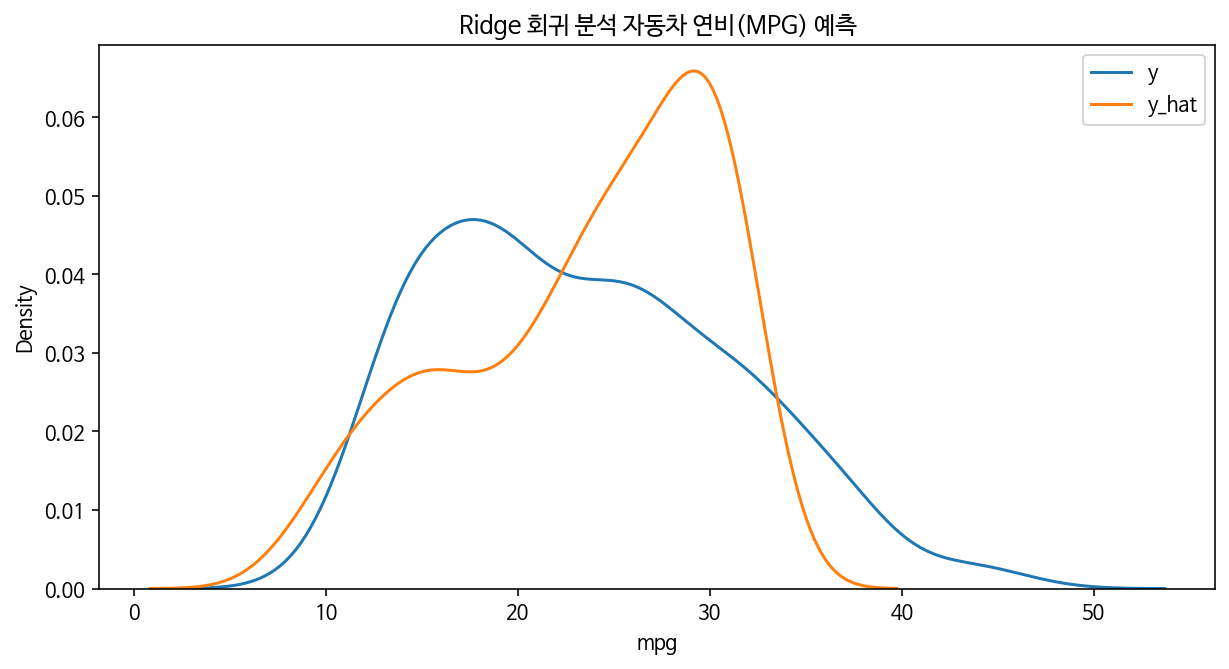

In [ ]:
plt.figure(figsize = (10, 5))
ax1 = sns.kdeplot(y, label = 'y')
ax2 = sns.kdeplot(y_hat, label = 'y_hat', ax=ax1)
plt.title('Ridge 회귀 분석 자동차 연비(MPG) 예측')
plt.legend()
plt.show()